# MuJoCO多参数并行实验
水平弹簧f1 100 刚度 771\
倾斜弹簧f2 290 刚度 2000\
连接球弹簧f3 计算 67000\
内部初始角速度 1000degree/s = 57.295779513 rad/s\
减速时扭矩 100Nm


| 测试 | 参数 | 范围       | 组数 |
|------|------|------------|------|
| 1    | z    | [0, 165]   | 240  |
| 2    | f1   | [20, 200]  | 240  |
| 3    | f2   | [150, 400] | 240  |


In [2]:
# 导入相关库
import re
import ast
import os
import sys
from time import time, sleep
import xml.etree.ElementTree as ET

import pandas as pd
import pickle
import numpy as np
import keyboard
import matplotlib.pyplot as plt

import mujoco.viewer as mj_viewer
import mujoco as mj

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)

from xlsxConverter import XLSXConverter
import tt12_with_middle as tt_csv

import tt12_control_0911 as tt_ctrl

def reload_module(module_name, alias=None):  
    import importlib  
    module = importlib.import_module(module_name)  
    importlib.reload(module)  

    globals()[alias] = module  # 将模块赋值给全局变量  
    return module

In [3]:
# 定义常量
z_list = np.linspace(0, 165, 240)
f1_list = np.linspace(20, 200, 240)
f2_list = np.linspace(150, 400, 240)
xlsx_path = '../data/xlsx/topology_TSR_flexible_strut_ball_foot_v1_R.xlsx'


In [4]:
def cal_ori_length(z=165, f1=100, f2=290):
    a=350/2
    z=165
    f3 = (f2/np.sqrt(2) - f1)*2*np.sqrt(a**2+z**2)/(a-z)
    stiffness1 = 771  # N/m    
    stiffness2 = 2000
    stiffness3 = 67000

    length1 = 0.35
    length2 = 0.35/2*np.sqrt(2)
    length3 = 0.35/2*np.sqrt(2)

    dx1 = f1/stiffness1
    dx2 = f2/stiffness2
    dx3 = f3/stiffness3
    ori_length1 = abs(dx1-length1)
    ori_length2 = abs(dx2-length2)
    ori_length3 = abs(dx3-length3)
    return ori_length1, ori_length2, ori_length3

def cal_experiment_param_4(z=165):
    return (175+z)*2*0.001
cal_ori_length()

(0.22029831387808038, 0.10248737341529165, 0.17205665109199625)

In [10]:
reload_module('tt12_control_0911', 'tt_ctrl')
reload_module('tt12_with_middle', 'tt_csv')

i=1
z=165
xlsx_path = '../data/xlsx/topology_TSR_flexible_strut_ball_foot_v1_R.xlsx'
for i, z in enumerate(z_list):
    csv_path = f'../data/csv/data_tt12bar_0911_{i}.csv'
    export_xml_file_path = '../data/xml/'
    export_xml_file_name = f"TT12_0911_{i}.xml"
    xml_path = export_xml_file_path + export_xml_file_name
    save_data_csv = f'../data/csv/0911/output_tt12bar_{i}.csv'

    param_length_4 = (175+z)*2*0.001

    tt12 = tt_csv.TT12WithMiddle(xlsx_path, param_length_4=param_length_4)
    tt12.fill_all_data(ori_length_1=0.22, ori_length_2=0.10, ori_length_3=0.18)
    tt12.export_to_csv(csv_path)
    tt12_mjcf = tt_ctrl.TT12_MJCF()  
    tt12_mjcf.time_step = 0.00001 
    # tt12_mjcf.floor_friction = '0.1 0.005 0.0001'  
    # tt12_mjcf.floor_solref = '-100000 -10'  
    tt12_mjcf.generate_tt_model(csv_path, tt_model_name='tt_model_0', pos=(0, 0, 0))  
    tt12_mjcf.export_to_xml_file(export_xml_file_path, export_xml_file_name)

    tt12_control = tt_ctrl.TT12_Control(xml_path, keyframe_id=0)  
    tt12_control.Hz = 200
    tt12_control.is_control=True
    tt12_control.simulate(is_render=False, stop_time=1)  
    # tt12_control.recorded_data.plot_data(attr_name_list=['angvel_inside_ball', 'outside_z_pos', 'torque'])
    tt12_control.recorded_data.save_data(save_data_csv)

In [5]:
import multiprocessing  

def process_z(z, index):  
    xlsx_path = '../data/xlsx/topology_TSR_flexible_strut_ball_foot_v1_R.xlsx'
    csv_path = f'../data/csv/data_tt12bar_0911_{index}.csv'  
    export_xml_file_path = '../data/xml/'  
    export_xml_file_name = f"TT12_0911_{index}.xml"  
    xml_path = export_xml_file_path + export_xml_file_name  
    save_data_csv = f'../data/csv/0911/output_tt12bar_{index}.csv'  

    param_length_4 = (175 + z) * 2 * 0.001  

    # 创建 TT12WithMiddle 实例并处理数据  
    tt12 = tt_csv.TT12WithMiddle(xlsx_path, param_length_4=param_length_4)  
    tt12.fill_all_data(ori_length_1=0.22, ori_length_2=0.10, ori_length_3=0.18)  
    tt12.export_to_csv(csv_path)  

    # 创建 TT12_MJCF 实例并生成模型  
    tt12_mjcf = tt_ctrl.TT12_MJCF()  
    tt12_mjcf.time_step = 0.00001  
    tt12_mjcf.generate_tt_model(csv_path, tt_model_name='tt_model_0', pos=(0, 0, 0))  
    tt12_mjcf.export_to_xml_file(export_xml_file_path, export_xml_file_name)  

    # 创建 TT12_Control 实例并进行仿真  
    tt12_control = tt_ctrl.TT12_Control(xml_path, keyframe_id=0)  
    tt12_control.Hz = 200  
    tt12_control.is_control = True  
    tt12_control.simulate(is_render=False, stop_time=1)  
    tt12_control.recorded_data.save_data(save_data_csv)

In [6]:
z_list = [0, 165]
with multiprocessing.Pool(processes=2) as pool:  
    pool.starmap(process_z, [(z, i) for i, z in enumerate(z_list)])  

In [1]:
z_list = np.linspace(0, 165, 240)
# 当i=x，求对应的z
for i in range(240):
    z = z_list[i]
    print(f"z={z:.2f}, x={x:.2f}")

24.0

Exiting simulation...


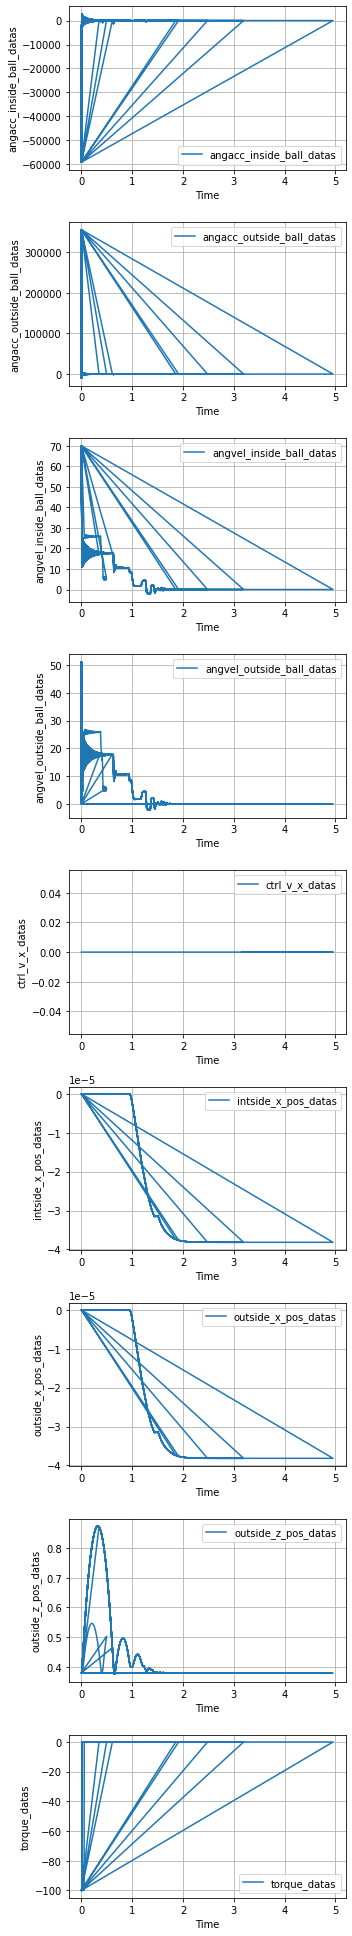

In [84]:
import mujoco as mj
import os
import sys

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)

from xlsxConverter import XLSXConverter
import tt12_with_middle as tt_csv

import tt12_control_0911 as tt_ctrl

def reload_module(module_name, alias=None):  
    import importlib  
    module = importlib.import_module(module_name)  
    importlib.reload(module)  

    globals()[alias] = module  # 将模块赋值给全局变量  
    return module

reload_module('tt12_control_0911', 'tt_ctrl')
reload_module('tt12_with_middle', 'tt_csv')

index = 1
xlsx_path = '../data/xlsx/topology_TSR_flexible_strut_ball_foot_v1_R.xlsx'
csv_path = f'../data/csv/data_tt12bar_0912_{index}.csv'  
export_xml_file_path = '../data/xml/'  
# export_xml_file_name = f"TT12_0912_{index}.xml"  
export_xml_file_name = f"TT12_0912.xml"  
xml_path = os.path.join(export_xml_file_path, export_xml_file_name)

# # 创建 TT12WithMiddle 实例并处理数据  
# tt12 = tt_csv.TT12WithMiddle(xlsx_path)  
# tt12.fill_all_data(ori_length_1=0.22, ori_length_2=0.10, ori_length_3=0.17)  
# tt12.export_to_csv(csv_path)  

# # 创建 TT12_MJCF 实例并生成模型  
# tt12_mjcf = tt_ctrl.TT12_MJCF()  
# tt12_mjcf.time_step = 0.00001  
# tt12_mjcf.generate_tt_model(csv_path, tt_model_name='tt_model_0', pos=(0, 0, 0))  
# tt12_mjcf.export_to_xml_file(export_xml_file_path, export_xml_file_name)
# # 创建 TT12_Control 实例并进行仿真  

tt12_control = tt_ctrl.TT12_Control(xml_path, keyframe_id=0)  
tt12_control.Hz = 2000  
tt12_control.is_control = True  
tt12_control.simulate(is_render=True, stop_time=5)
tt12_control.recorded_data.plot_all_data()
# tt12_control.recorded_data.save_data(save_data_csv)

In [91]:
import mujoco as mj
import os
import sys

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)

from xlsxConverter import XLSXConverter
import tt12_with_middle as tt_csv

import tt12_control_0911 as tt_ctrl

def reload_module(module_name, alias=None):  
    import importlib  
    module = importlib.import_module(module_name)  
    importlib.reload(module)  

    globals()[alias] = module  # 将模块赋值给全局变量  
    return module

reload_module('tt12_control_0911', 'tt_ctrl')
reload_module('tt12_with_middle', 'tt_csv')

index = 1
xlsx_path = '../data/xlsx/topology_TSR_flexible_strut_ball_foot_v1_R.xlsx'
csv_path = f'../data/csv/data_tt12bar_0912_{index}.csv'  
export_xml_file_path = '../data/xml/'  
# export_xml_file_name = f"TT12_0912_{index}.xml"  
export_xml_file_name = f"TT12_0913_1.xml"  
xml_path = os.path.join(export_xml_file_path, export_xml_file_name)

# # 创建 TT12WithMiddle 实例并处理数据  
# tt12 = tt_csv.TT12WithMiddle(xlsx_path, displacement=(0,0,0.38))  
# tt12.fill_all_data(ori_length_1=0.22, ori_length_2=0.10, ori_length_3=0.17)  
# tt12.export_to_csv(csv_path)  

# # 创建 TT12_MJCF 实例并生成模型  
# tt12_mjcf = tt_ctrl.TT12_MJCF()  
# tt12_mjcf.time_step = 0.00001  
# tt12_mjcf.generate_tt_model(csv_path, tt_model_name='tt_model_0', pos=(0, 0, 0))  
# tt12_mjcf.export_to_xml_file(export_xml_file_path, export_xml_file_name)
# # 创建 TT12_Control 实例并进行仿真  

tt12_control = tt_ctrl.TT12_Control(xml_path, keyframe_id=None)  
tt12_control.Hz = 2000  
tt12_control.is_control = True  
tt12_control.simulate(is_render=True, stop_time=10)
tt12_control.recorded_data.plot_all_data()
# tt12_control.recorded_data.save_data(save_data_csv)

[ 1.79416233e-01  1.79416233e-01  3.79760351e-01  9.99999994e-01
 -7.70437980e-05  7.70437980e-05  2.97452295e-17 -1.79416233e-01
  1.79416233e-01  3.79760351e-01  9.99999994e-01 -7.70437980e-05
 -7.70437980e-05 -8.40330582e-18 -1.79416233e-01 -1.79416233e-01
  3.79760351e-01  9.99999994e-01  7.70437980e-05 -7.70437980e-05
 -7.60326852e-18  1.79416233e-01 -1.79416233e-01  3.79760351e-01
  9.99999994e-01  7.70437980e-05  7.70437980e-05 -1.07715324e-17
  1.79423081e-01 -6.31179769e-16  5.58788802e-01  1.00000000e+00
 -1.57620342e-19 -2.24118809e-17 -6.29788296e-16  1.79409422e-01
 -6.55192773e-16  1.99956290e-01  1.00000000e+00  3.54849914e-17
 -3.54930869e-16 -5.08410959e-16 -1.79409422e-01 -3.32318752e-16
  1.99956290e-01  1.00000000e+00  3.62082379e-17 -2.34922935e-16
 -5.15194283e-16 -1.79423081e-01 -3.08676648e-16  5.58788802e-01
  1.00000000e+00  1.32257319e-17  2.98195145e-18 -6.13760197e-16
  8.79708346e-16  1.79423081e-01  5.58788802e-01  1.00000000e+00
  2.31714620e-16  1.02416

In [90]:
a = np.array([1, 2, 3, 4, 5])
# 将数组转换为字符串，且每个元素用空格分开
b = ' '.join(map(str, a))
b

'1 2 3 4 5'